In [319]:
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from finta import TA
import pandas as pd
import plotly.graph_objects as go
import numpy as np
sns.set(rc={'figure.figsize':(11.7,8.27)})

class stock():
    
    """"The name_methods_show() only show the indicator  they related to, 
    between start and end, whereas the name_methods() output a dataframe 
    containing the values on the entire dataset"""
    
    def __init__(self,name):
        self.stock_df = pd.DataFrame(yf.Ticker(name).history(period="max"))
        self.stock_df.columns = map(str.lower, self.stock_df.columns)
        self.name = name
        
    def Bollinger_bands_show(self,start,end, width = False , upper = True, lower = True):
        #La courbe représentant le cours de l'action suit une moyenne mobile à 7 jours(choix arbitraire)
        self.stock_df.columns = map(str.lower, self.stock_df.columns)
        bbands = TA.BBANDS(self.stock_df)
        sns.set()
        if upper :
            bbands[start:end].BB_UPPER.plot()
        if lower :
            bbands[start:end].BB_LOWER.plot()
        

        self.stock_df["open"][start:end].rolling(window=7, center =True).mean().plot(label="MA 7 jours",ls = ":")
        plt.show()
        if width :
            width = TA.BBWIDTH(self.stock_df)
            width[start:end].plot(label="Width", lw =3)
            plt.show()
        
    def cours_show(self):
        #Affiche le cours de l'action

        fig = go.Figure(data=go.Ohlc(x=self.stock_df.index,
            open=self.stock_df['open'],
            high=self.stock_df['high'],
            low=self.stock_df['low'],
            close=self.stock_df['close']))
        fig.show()
        
    def EMA_show(self,start,end):
        #Exponential Moving Average
        TA.EMA(self.stock_df)[start:end].plot()
        plt.show()
        
    def RSI_show(self,start,end):
        #Relative Strengh Indicator
        TA.RSI(self.stock_df)[start:end].plot()
        plt.show()
        
    def ROC_show(self,start,end):
        #Rate of Change
        TA.ROC(self.stock_df)[start:end].plot()
        plt.show()
        
    def MOM_show(self,start,end):
        #Rate of Change
        TA.ROC(self.stock_df)[start:end]

        return()
    
    def EMA(self):
        #Exponential Moving Average
        return TA.EMA(self.stock_df)
        
    def RSI(self):
        #Relative Strengh Indicator
        return TA.RSI(self.stock_df)
        
    def ROC(self):
        #Rate of Change
        return TA.ROC(self.stock_df)
        
    def MOM(self):
        #Momentum
        return TA.MOM(self.stock_df)
    
    def Bollinger_bands(self):
        return TA.BBANDS(self.stock_df)
    
    def Bollinger_width(self):
        return TA.BBWIDTH(self.stock_df)
    
    def price(self, var="open"):
        return(self.stock_df[var])
     
        
        
        
        

In [326]:
cac40 = stock(name="^FCHI")
cac40.cours_show()

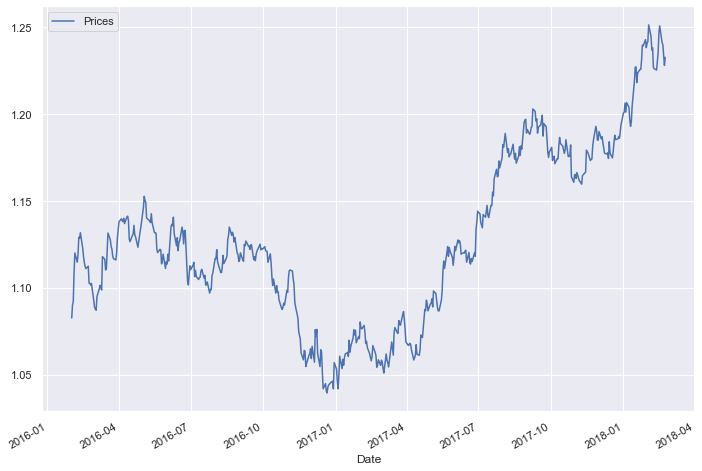

In [347]:
#Création du dataset pour créer le model :
stock_ds = stock(name="EURUSD=X")

#Résultats plutôt bons pour le crédit Agricole : ACA.PA, pour APPLE : AAPL, étranges pour MSFT, moyens pour AMZN



""""The only indicators taken into account are, for now : 
Relative Strenght Indicator, 
Momentum of Market, 
Bollinger Bands width, 
Rate of Change, 
Prices (not of the forcasted period of course)"""

X = pd.DataFrame({"RSI" : stock_ds.RSI(), 
                  "MOM" : stock_ds.MOM(), 
                  "Bollinger Width" : stock_ds.Bollinger_width(), 
                  "ROC" : stock_ds.ROC(),
                 "Prices" : stock_ds.price()})

y = pd.DataFrame({"Prices" : stock_ds.price()})

X,y = X.dropna(), y.dropna()

""""The segmentation of the train/test datasets are arbitrary. 
The forcasting period is expected to be Month+1
We expect to encounter some size issues as markets are not open 365/365 days 
and the closing days are not excatly the same every day"""

X_train = X["2014-01":"2016-01"]
y_train = y["2016-02":"2018-02-25"]

X_test = X["2019-01-03":"2019-08"]
y_test = y["2019-02":"2019-09"]

y_train.plot()
plt.show()


/Users/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



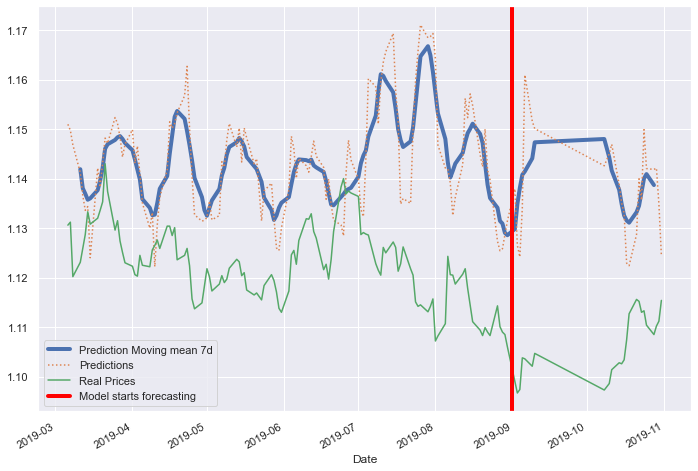

In [351]:


X_end = "2019-09"

X_test = X["2019-02":X_end]
y_test = y["2019-03-06":"2019-10"]

"""" Below stands a way of dealing with the size issue of training datasets.
It's a degree 0 way of dealing with it. There are certainly more efficient 
ways to handle it"""

if len(y_train)-len(X_train)>0 : y_train= y_train[:-abs(len(y_train)-len(X_train))]
if len(y_train)-len(X_train)<0 : X_train= X_train[:-abs(len(y_train)-len(X_train))]
    

    
"""" The ML model chosen is SVR because of the architecture of the output.
Chosing a linear Kernel is arbitrary, could be improved"""

from sklearn.svm import SVR

model = SVR(kernel="linear")
model.fit(X_train, np.ravel(y_train))
y_pred = model.predict(X_test)

"""" Same situation, we have to equalize the size of the test datasets"""

if len(y_test)-len(y_pred)>0 : 
    y_test= y_test[:-abs(len(y_test)-len(y_pred))]
    if len(y_test)-len(y_pred)!=0 : raise ValueError("L'ajustement ne fonctionne pas, y_test est trop long")
if len(y_test)-len(y_pred)<0 : 
    y_pred= y_pred[:-abs(len(y_test)-len(y_pred))]
    if len(y_test)-len(y_pred)!=0 : raise ValueError("L'ajustement ne fonctionne pas, y_pred est trop long")

    
    
"""" Plotting the real prices and the predictions to have a visual assession of 
the quality of our model"""

y_test["Predictions"] = y_pred
y_test["Pred_mean"] = y_test["Predictions"].rolling(window=7, center =True).mean().plot(label="Prediction Moving mean 7d",lw = 4)
y_test["Predictions"].plot(label = "Predictions", ls = ":")
y_test["Prices"].plot(label="Real Prices")

plt.axvline(label = "Model starts forecasting" , x=X_end, ymin=0, ymax=190, lw = 4, color = "red")
plt.legend()
plt.show()

